In [20]:
import matplotlib.pyplot as plt # for seeing the images
%matplotlib inline
import os
import cv2 # for image processing
import glob # for file handling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output # to get the files in currect folder
from keras.utils import to_categorical # to convert to one-hot encodings
import tqdm # progress bar
from collections import Counter # for getting breed data
from dnn_app_utils_v3 import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [4]:
# loading images path --> train
images_train_path = 'C:\\Users\\mahmo\\Downloads\\Dog Breed Identification\\Experiment\\train\\*.jpg'
images_train_paths = glob.glob(images_train_path)
print(images_train_paths[0])




C:\Users\mahmo\Downloads\Dog Breed Identification\Experiment\train\000bec180eb18c7604dcecc8fe0dba07.jpg


In [5]:
# laoding images path --> test
images_test_path = 'C:\\Users\\mahmo\\Downloads\\Dog Breed Identification\\Experiment\\test\\*.jpg'
images_test_paths = glob.glob(images_test_path)
print(images_test_paths[0])

C:\Users\mahmo\Downloads\Dog Breed Identification\Experiment\test\00a3edd22dc7859c487a64777fc8d093.jpg


In [6]:
# taking the labels for the images
labels = pd.read_csv('C:\\Users\\mahmo\\Downloads\\Dog Breed Identification\\labels.csv')
print(labels.head())


                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [106]:
experiment_lables = labels[:20]
experiment_lables.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [107]:
# taking the labels and converting to one hot
breeds = sorted(list(set(experiment_lables['breed'].values)))
# making a dictionary of breeds which will be used for one-hot encoding
b2id = dict((b,i) for i,b in enumerate(breeds))
# converting labeled breeds to numbers
breed_vector = [b2id[i] for i in experiment_lables['breed'].values]
# converting to one-hot encoding
data_y = pd.get_dummies(breed_vector)
print('[*]Total images:', len(images_test_paths) + len(images_train_paths))
print('[*]Total training images:', len(images_train_paths))
print('[*]Total test images:', len(images_test_paths))
print('[*]Total breeds:',len(breeds))
print('[*]data_y.shape:', data_y.shape)
print(data_y[0])

[*]Total images: 40
[*]Total training images: 20
[*]Total test images: 20
[*]Total breeds: 18
[*]data_y.shape: (20, 18)
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    1
16    0
17    0
18    0
19    0
Name: 0, dtype: uint8


In [108]:
# understanding the distribution of breeds
breed_dict = Counter(labels['breed'].values)
# getting top 5 breeds
breed_numbers = [i for i in breed_dict.values()]
breed_names = [b for b in breed_dict.keys()]

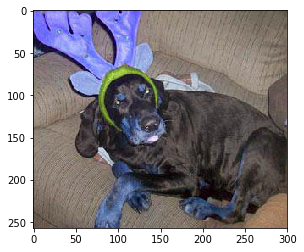

In [109]:
# taking a sample image
img1 = cv2.imread(images_train_paths[5])
plt.imshow(img1)


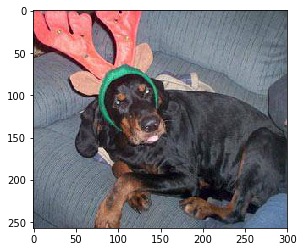

In [110]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)


(64, 64, 3)


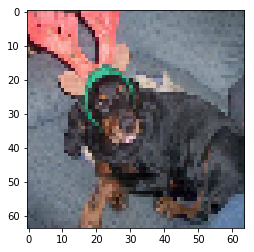

In [86]:
# Resizing an image to a sqaure
img1 = cv2.resize(img1, (64, 64))
plt.imshow(img1)
# converting to the image to array which will be understood by the model
print(img1.shape)

In [65]:
print('[!]Getting training images:')
total_images_train = np.zeros((len(images_train_paths), 64, 64, 3))
for i in tqdm.tqdm(range(len(images_train_paths))):
    image = cv2.imread(images_train_paths[i]) # reading the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converting to proper colour channel
    image = cv2.resize(image, (64,64)) # resizing to feed into model
    total_images_train[i] = image # adding to the total data


[!]Getting training images:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 176.70it/s]


In [66]:
print('[!]Getting testing images:')
total_images_test = np.zeros((len(images_test_paths), 64, 64, 3))
for i in tqdm.tqdm(range(len(images_test_paths))):
    image = cv2.imread(images_test_paths[i]) # reading the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converting to proper colour channel
    image = cv2.resize(image, (64,64)) # resizing to feed into model
    total_images_test[i] = image # adding to the total data

[!]Getting testing images:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 284.82it/s]


In [67]:
total_images_train = np.array(total_images_train)
# total_images_test = np.array(total_images_test)


In [68]:
print('[*]Traning set shape:', total_images_train.shape)
# print('[*]Testing set shape:', total_images_test.shape)

[*]Traning set shape: (20, 64, 64, 3)


In [103]:
# Reshape the training and test examples 
train_x_flatten = total_images_train.reshape(total_images_train.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = total_images_test.reshape(total_images_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 20)
test_x's shape: (12288, 20)


## Two-layer neural network

In [87]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [88]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x,n_h,n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X,W1,b1,'relu')
        A2, cache2 = linear_activation_forward(A1,W2,b2,'sigmoid')
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2,Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2,cache2,'sigmoid')
        dA0, dW1, db1 =  linear_activation_backward(dA1,cache1,'relu')
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters,grads,learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [89]:
parameters = two_layer_model(train_x, data_y, layers_dims = (n_x, n_h, n_y), 
                             num_iterations = 2500, print_cost=True)

AssertionError: 

##  L-layer Neural Network Model

In [78]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [79]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X,parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL,Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL,Y,caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [80]:
parameters = L_layer_model(train_x, data_y, 
                           layers_dims, num_iterations = 2500, print_cost = True)

ValueError: shapes (20,18) and (20,1) not aligned: 18 (dim 1) != 20 (dim 0)

## CNN Model with Keras

In [90]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2, padding = 'same',
                 activation = 'relu', input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size= 2))
model.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size= 2))
model.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size= 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(len(breeds), activation = 'softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 64)          0         
__________

In [94]:
# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [111]:
model.fit(total_images_train, data_y,  epochs = 10, batch_size = 64)

ValueError: Error when checking target: expected dense_6 to have shape (20,) but got array with shape (18,)